In [0]:
# Import libraries
import requests
import pandas as pd
import re
import numpy as np

np.set_printoptions(suppress=True)


# Data viz libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Pyspark Libraries
from pyspark.sql.types import StringType
from pyspark.sql.functions import (regexp_extract, col, regexp_replace, lit, when, concat_ws, expr,
                                size, trim, split, lpad, lower, coalesce, count, row_number, first,
                                 avg, median)

from pyspark.sql.window import Window

import shutil


In [0]:
# Defining the layer ouro database, where analysis will take place

# Create new database with custom DBFS location
spark.sql("""
CREATE DATABASE IF NOT EXISTS ouro_imoveis
LOCATION 'dbfs:/mvp/database/ouro_imoveis'
""")

Out[2]: DataFrame[]

####Open datasets

In [0]:
# open datasets imoveis rio e sp wih pandas, better for data analysis and charts

df_rio = spark.table('silver_imoveis.imoveis_rio')
display(df_rio.sample(0.002))

pd_rio = df_rio.toPandas()

ID_imovel,Link,Titulo,Endereco,Bairro,Cep,Preco,Condominio,IPTU,Area,Dormitorios,Banheiros,Garagem
21010746,/imovel/apartamento-3-quartos-copacabana-zona-sul-rio-de-janeiro-com-garagem-230m2-aluguel-RS6000-id-2762922216/,Imóvel para aluguel possui 230 metros quadrados com 3 quartos em Copacabana - Rio de Janeiro - RJ,"Rua Tonelero, 7",Copacabana,22030001,6000.0,2300.0,651.0,230,3,3,1
21011144,/imovel/apartamento-2-quartos-jardim-botanico-zona-sul-rio-de-janeiro-60m2-aluguel-RS3500-id-2791151145/,Imóvel para alugar de 60m² com Sala e 2 Quartos - Jardim Botânico - Rio de Janeiro - RJ,"Rua Pacheco Leão,",Jardim Botânico,22460030,3500.0,900.0,236.0,60,2,1,0
21011188,/imovel/apartamento-2-quartos-copacabana-zona-sul-rio-de-janeiro-com-garagem-75m2-aluguel-RS4200-id-2645217797/,Apartamento para aluguel com 75 metros quadrados com 2 quartos,"Rua Santa Clara, 245",Copacabana,22041011,4200.0,1300.0,250.0,75,2,2,1
21023609,0,Apartamento mobiliado em Botafogo com 3 quartos e 1 vaga disponível para locação.,"rio de janeiro, botafogo",botafogo,22231000,6300.0,2083.0,3395.0,80,3,3,1
21023541,0,Alugo Bar/Loja Santa Teresa- FALLET,"rio de janeiro, santa teresa",santa teresa,20230000,1700.0,null,null,150,0,0,0
21030255,https://www.zapimoveis.com.br/imovel/aluguel-quitinete-1-quarto-copacabana-rio-de-janeiro-25m2-id-2774089721/,aluguel-quitinete-1-quarto-copacabana,null,copacabana,22010000,1200.0,780.0,100.0,25,1,1,0


In [0]:

df_sp = spark.table('silver_imoveis.imoveis_sp')
display(df_sp.sample(0.002))

pd_sp = df_sp.toPandas()

ID_imovel,Link,Titulo,Endereco,Bairro,Cep,Preco,Condominio,Iptu,Area,Dormitorios,Banheiros,Garagem
11021116,0,Imóvel para aluguel tem 62 metros quadrados com 2 quartos em Lapa - São Paulo - SP,"são paulo, lapa",lapa,05038090,3890.0,900.0,355.0,62,2,2,null
11021251,0,Sobrado com 4 quartos à venda ou para locação em Parque Dos Príncipes - SP,"são paulo, parque dos príncipes",parque dos príncipes,05396000,20000.0,0.0,1900.0,650,4,5,null
11021467,0,"Apartamento, Perdizes - São Paulo","são paulo, perdizes",perdizes,01156970,5500.0,1090.0,410.0,67,2,2,null
11022121,0,Apartamento Duplex Para Locação - 2 Dormitórios - 2 Vagas - Pinheiros,"são paulo, pinheiros",pinheiros,01458970,13000.0,3000.0,950.0,140,2,3,null
11023836,0,APARTAMENTO - POMPÉIA - SP,"são paulo, sumaré",sumaré,01251001,12500.0,3400.0,2377.0,240,4,5,null
11024050,0,"Apartamento para locação com 78m²au, 2 dorms/1 suíte, 2 vagas na Vilaa Leopoldina","são paulo, vila hamburguesa",vila hamburguesa,05302020,3400.0,1200.0,364.0,78,2,3,null
11031104,https://www.zapimoveis.com.br/imovel/aluguel-apartamento-2-quartos-com-varanda-perdizes-sao-paulo-140m2-id-2790695824/,"Perdizes, São Paulo",rua diana,perdizes,05019000,6996.0,2800.0,740.0,140,2,2,4
11031111,null,"Pinheiros, São Paulo",rua diogo moreira,pinheiros,05423010,2501.0,1800.0,199.0,26,1,1,1
11031355,https://www.zapimoveis.com.br/imovel/venda-apartamento-5-quartos-com-piscina-perdizes-sao-paulo-240m2-id-1962945473/,"Perdizes, São Paulo",rua tavares bastos,perdizes,05012020,14000.0,2800.0,14119.0,240,5,7,5
11011330,https://www.vivareal.com.br/imovel/apartamento-4-quartos-perdizes-sao-paulo-com-garagem-500m2-aluguel-RS60000-id-2785089529/,"Perdizes, São Paulo",null,perdizes,05016099,60000.0,7000.0,52451.0,500,4,6,6


## Análise Exploratória

In [0]:
# Applying a plot style to the charts

#plt.style.use('seaborn-v0_8')

sns.set_style('darkgrid', {'grid.color': '.8',
                           'grid.linestyle': '-',
                           'text.color': '.2',
                           'xtick.color': 'dimgray',
                           'ytick.color': 'dimgray',
                           'axes.labelcolor': 'dimgray'})

# Defining a color pallete

colors = ['midnightblue', 'grey', 'cornflowerblue', 'silver', 'lightsteelblue', 'gainsboro']
sns.set_palette(sns.color_palette(colors))

In [0]:
# Convert float to int, as separator "." in pandas means thousands indicator

pd_rio = pd_rio.apply(lambda x: x.astype('Int64') if x.dtype == 'float' else x)

pd_sp = pd_sp.apply(lambda x: x.astype('Int64') if x.dtype =='float' else x)

### Avaliação das distribuições das colunas numéricas de preços

In [0]:
pd_rio = pd_rio.rename(columns={'IPTU': 'Iptu'})

In [0]:
# Transform names in column Bairro
pd_rio['Bairro'] = pd_rio['Bairro'].str.title()
pd_sp['Bairro'] = pd_sp['Bairro'].str.title()

In [0]:
# Make a copy of dfs to keep original records of distributions beore dropping outliers

pd_rio_orig = pd_rio.copy()

pd_sp_orig = pd_sp.copy()


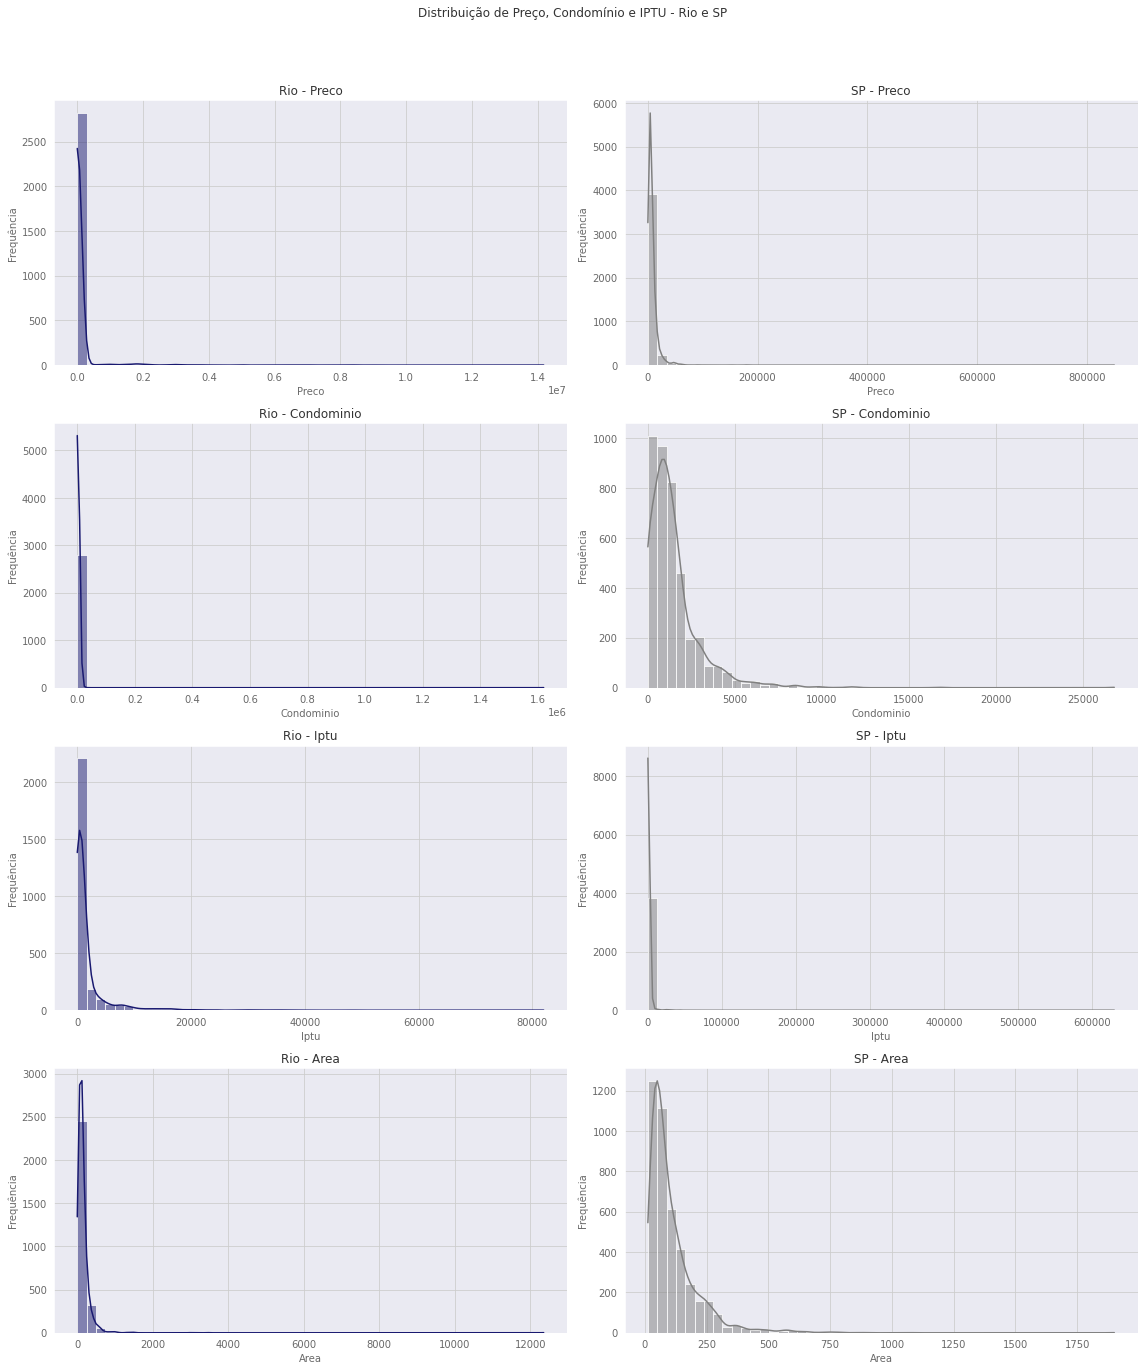

In [0]:
# Plot histograms to search for patterns in distributions for Rio de Janeiro and São Paulo
# Using original datasets

col_num = ['Preco', 'Condominio', 'Iptu', 'Area']

fig, axes = plt.subplots(4, 2, figsize=(16, 20))  # 4 linhas (uma pra cada variável) e 2 colunas (rio, sp) 
fig.suptitle("Distribuição de Preço, Condomínio e IPTU - Rio e SP")

for i, col in enumerate(col_num):
    # Rio
    sns.histplot(x=col, data=pd_rio_orig, kde=True, bins=50, ax=axes[i, 0], color=colors[0])
    axes[i, 0].set_title(f'Rio - {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequência')

    # SP
    sns.histplot(x=col, data=pd_sp_orig, kde=True, bins=50, ax=axes[i, 1], color=colors[1])
    axes[i, 1].set_title(f'SP - {col}')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Frequência')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Distribuições muito assimétricas, podem atrapalhar a análise. 

Necessidade de investigar outliers e removê-los da base de dados.

In [0]:
# There are too many outliers... 
# # Let's investigate based on discretization groups
# Column preco RJ

Q1 = pd_rio['Preco'].quantile(0.25)
print(f"Q1 RJ: {Q1}")
Q3 = pd_rio['Preco'].quantile(0.75)
print(f"Q3 RJ: {Q3}")
Q9 = pd_rio['Preco'].quantile(0.90)
print(f"Q9 RJ: {Q9}")
Q95 = pd_rio['Preco'].quantile(0.95)
print(f"Q95 RJ: {Q95}")

Q1 RJ: 4200
Q3 RJ: 14000
Q9 RJ: 25000
Q95 RJ: 44199.99999999982


In [0]:
# Apply same logic to são paulo
# Column Preço SP

Q1 = pd_sp['Preco'].quantile(0.25)
print(f"Q1 SP: {Q1}")
Q3 = pd_sp['Preco'].quantile(0.75)
print(f"Q3 SP: {Q3}")
Q9 = pd_sp['Preco'].quantile(0.90)
print(f"Q9 SP: {Q9}")
Q95 = pd_sp['Preco'].quantile(0.95)
print(f"Q95 SP: {Q95}")

Q1 SP: 3100
Q3 SP: 8996
Q9 SP: 15000
Q95 SP: 22000


In [0]:
# Condominio column RJ

Q1 = pd_rio['Condominio'].quantile(0.25)
print(f'Q1 RJ= {Q1}')
Q3 = pd_rio['Condominio'].quantile(0.75)
print(f'Q3 RJ= {Q3}')
Q9 = pd_rio['Condominio'].quantile(0.90)
print(f'Q9 RJ= {Q9}')
Q975 = pd_rio['Condominio'].quantile(0.975)
print(f'Q975 RJ= {Q975}')

Q1 RJ= 1003
Q3 RJ= 2667
Q9 RJ= 4133.200000000002
Q975 RJ= 6209.999999999991


In [0]:
# Condominio column SP

Q1 = pd_sp['Condominio'].quantile(0.25)
print(f'Q1 SP= {Q1}')
Q3 = pd_sp['Condominio'].quantile(0.75)
print(f'Q3 SP= {Q3}')
Q9 = pd_sp['Condominio'].quantile(0.90)
print(f'Q9 SP= {Q9}')
Q975 = pd_sp['Condominio'].quantile(0.975)
print(f'Q975 SP= {Q975}')

Q1 SP= 533
Q3 SP= 1828
Q9 SP= 3188
Q975 SP= 5516


In [0]:
# IPTU column RJ

Q1 = pd_rio['Iptu'].quantile(0.25)
print(f'Q1 RJ= {Q1}')
Q3 = pd_rio['Iptu'].quantile(0.75)
print(f'Q3 RJ= {Q3}')
Q9 = pd_rio['Iptu'].quantile(0.90)
print(f'Q9 RJ= {Q9}')
Q975 = pd_rio['Iptu'].quantile(0.975)
print(f'Q975 RJ= {Q975}')

Q1 RJ= 271
Q3 RJ= 1152
Q9 RJ= 3946.300000000004
Q975 RJ= 12847


In [0]:
# IPTU column SP

Q1 = pd_sp['Iptu'].quantile(0.25)
print(f'Q1 SP= {Q1}')
Q3 = pd_sp['Iptu'].quantile(0.75)
print(f'Q3 SP= {Q3}')
Q9 = pd_sp['Iptu'].quantile(0.90)
print(f'Q9 SP= {Q9}')
Q975 = pd_sp['Iptu'].quantile(0.975)
print(f'Q975 SP= {Q975}')

Q1 SP= 120
Q3 SP= 740
Q9 SP= 1784.7999999999993
Q975 SP= 4500


In [0]:
# Area column Rio

Q1 = pd_rio['Area'].quantile(0.25)
print(f'Q91 RJ= {Q1}')
Q3 = pd_rio['Area'].quantile(0.75)
print(f'Q3 RJ= {Q3}')
Q9 = pd_rio['Area'].quantile(0.90)
print(f'Q9 RJ= {Q9}')
Q975 = pd_rio['Area'].quantile(0.975)
print(f'Q975 RJ= {Q975}')

Q91 RJ= 70
Q3 RJ= 170
Q9 RJ= 270
Q975 RJ= 500


In [0]:
# Area column SP

Q1 = pd_sp['Area'].quantile(0.25)
print(f'Q91 SP= {Q1}')
Q3 = pd_sp['Area'].quantile(0.75)
print(f'Q3 SP= {Q3}')
Q9 = pd_sp['Area'].quantile(0.90)
print(f'Q9 SP= {Q9}')
Q975 = pd_sp['Area'].quantile(0.975)
print(f'Q975 SP= {Q975}')

Q91 SP= 44
Q3 SP= 140
Q9 SP= 240
Q975 SP= 387.4499999999989


In [0]:
# Remove 5% of the highest prices - outliers - after this operation, the dataset`s distribution will be better represented 

pd_rio = pd_rio[pd_rio['Preco'] < 44000]

pd_sp = pd_sp[pd_sp['Preco'] < 22000]

In [0]:
# Remove 2,5% of highest values - outliers - Condominio column

pd_rio = pd_rio[pd_rio['Condominio'] < 6200]

pd_sp = pd_sp[pd_sp['Condominio'] < 5500]

In [0]:
#Remove 2,5% of highest values - outliers

pd_rio = pd_rio[pd_rio['Iptu'] < 12800]

pd_sp = pd_sp[pd_sp['Iptu'] < 4500]

In [0]:
#Remove 2,5% of highest values - outliers - Area column

pd_rio = pd_rio[pd_rio['Area'] < 500]

pd_sp = pd_sp[pd_sp['Area'] < 385]

**Distribuições após remoção de Outliers**

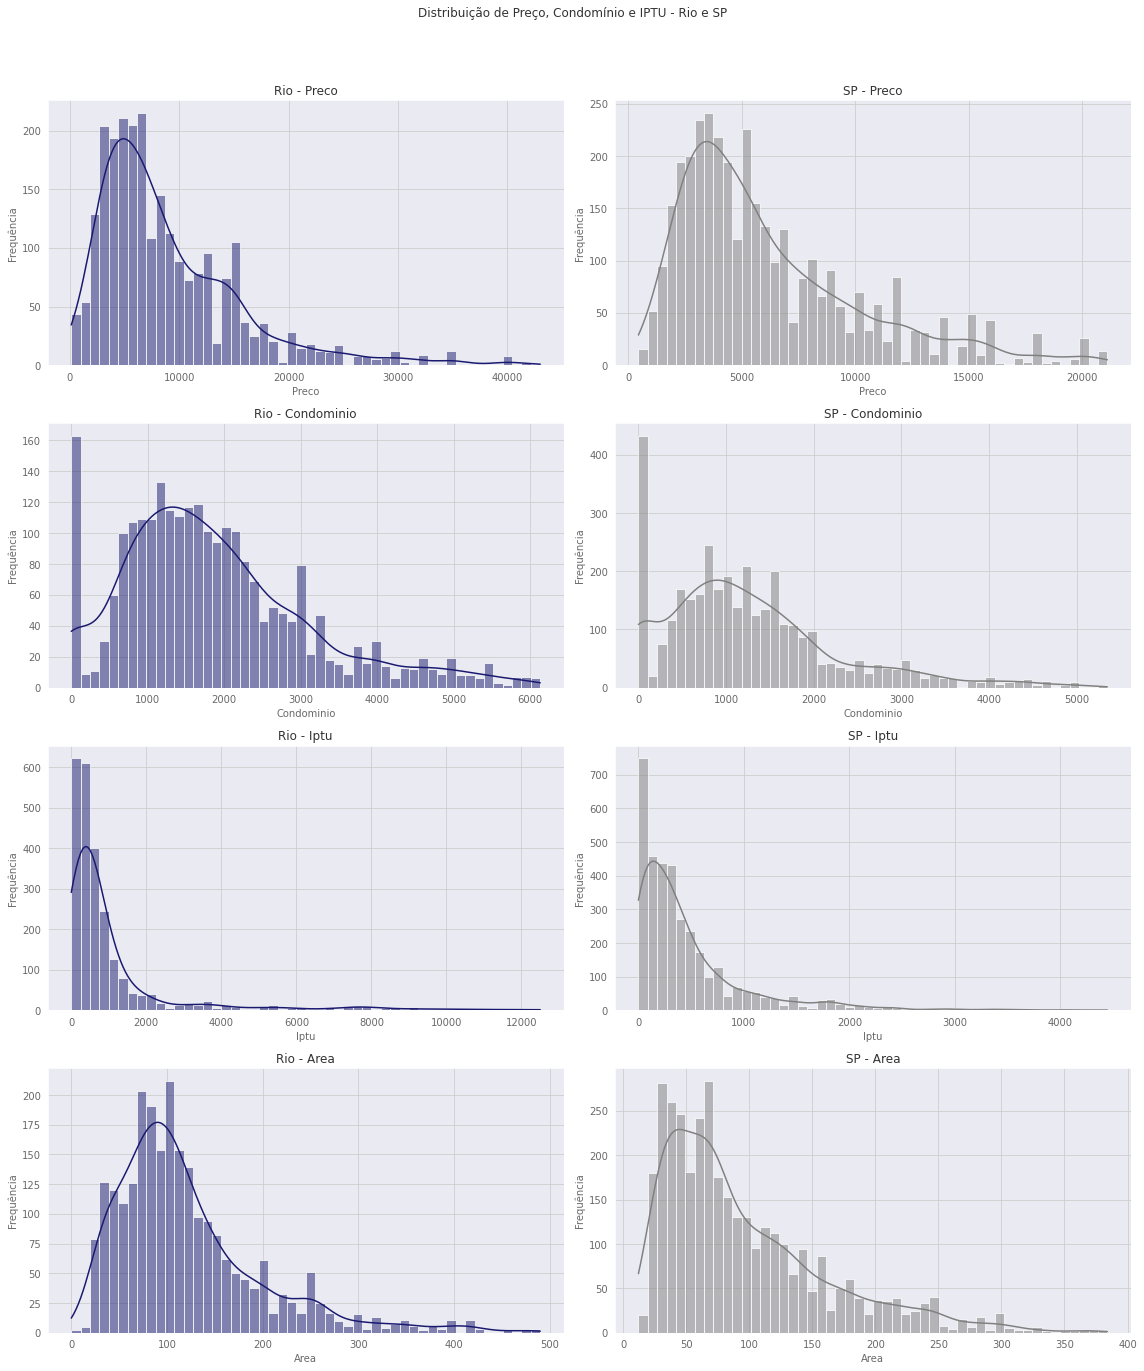

In [0]:
# Plot histograms to inspect distributions after dropping outliers for Rio de Janeiro and São Paulo

col_num = ['Preco', 'Condominio', 'Iptu', 'Area']

fig, axes = plt.subplots(4, 2, figsize=(16, 20))  # 4 linhas (uma pra cada variável) e 2 colunas (rio, sp) 
fig.suptitle("Distribuição de Preço, Condomínio e IPTU - Rio e SP")

for i, col in enumerate(col_num):
    # Rio
    sns.histplot(x=col, data=pd_rio, kde=True, bins=50, ax=axes[i, 0], color=colors[0])
    axes[i, 0].set_title(f'Rio - {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frequência')

    # SP
    sns.histplot(x=col, data=pd_sp, kde=True, bins=50, ax=axes[i, 1], color=colors[1])
    axes[i, 1].set_title(f'SP - {col}')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Frequência')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#####Conclusão

As distribuções das variáveis Preço, Condomínio, Iptu e Área apresentavam grande assimetria devido à presença de outliers (valores muito discrepantes em relação ao esperado), principalmente na variável preço.

Ao remover entre 2.5% e 5% dos dados da parte direita (ou superior) da distribuição, eliminamos este problema , como observado nos histogramas pós remoção dos outliers.

### Estatísticas Univariadas Básicas

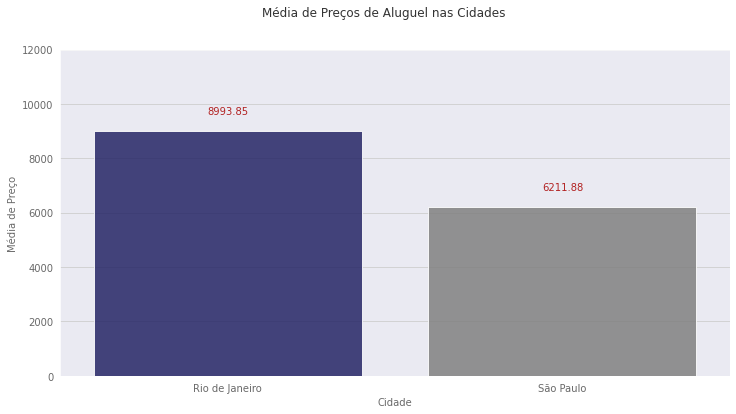

In [0]:
# Mean price per city

media_rj = pd_rio['Preco'].mean()
media_sp = pd_sp['Preco'].mean()

df_means= pd.DataFrame({'Cidade': ['Rio de Janeiro', 'São Paulo'], 'Média de Preço': [ media_rj, media_sp]})

# Plot a bar chart 
fig, axes = plt.subplots(figsize= (12,6))
fig.suptitle('Média de Preços de Aluguel nas Cidades')
ax1 = sns.barplot(x= 'Cidade', y= 'Média de Preço', data = df_means, alpha= 0.85)
ax1.bar_label (ax1.containers[0], fontsize= 10, color='firebrick', padding= 15, fmt= "%.2f")
ax1.set_ylim(0,12000)
plt.show()

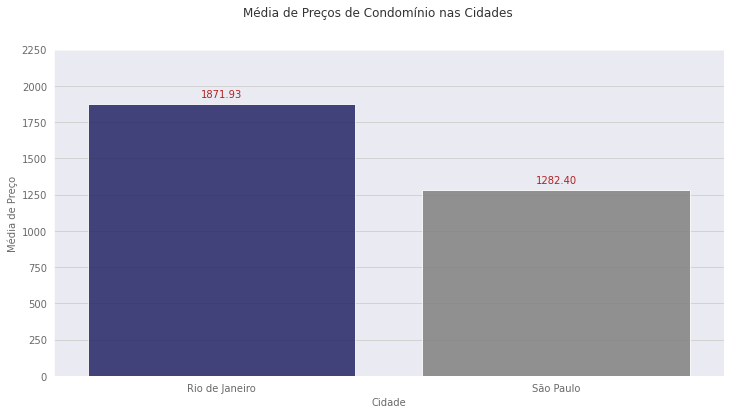

In [0]:
# Mean condominio per city

media_rj = pd_rio['Condominio'].mean()
media_sp = pd_sp['Condominio'].mean()

df_means= pd.DataFrame({'Cidade': ['Rio de Janeiro', 'São Paulo'], 'Média de Condomínio': [ media_rj, media_sp]})

# Plot a bar chart 
fig, axes = plt.subplots(figsize= (12,6))
fig.suptitle('Média de Preços de Condomínio nas Cidades')
ax1 = sns.barplot(x= 'Cidade', y= 'Média de Condomínio, data = df_means, alpha= 0.85)
ax1.bar_label (ax1.containers[0], fontsize= 10, color='firebrick', padding= 5, fmt= "%.2f")
ax1.set_ylim(0, 2250)

plt.show()

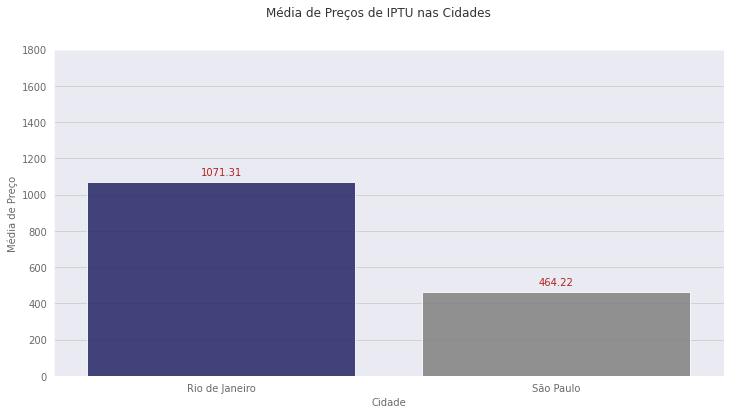

In [0]:
# Mean iptu per city

media_rj = pd_rio['Iptu'].mean()
media_sp = pd_sp['Iptu'].mean()

df_means= pd.DataFrame({'Cidade': ['Rio de Janeiro', 'São Paulo'], 'Média de IPTU: [ media_rj, media_sp]})

# Plot a bar chart 
fig, axes = plt.subplots(figsize= (12,6))
fig.suptitle('Média de Preços de IPTU nas Cidades')
ax1 = sns.barplot(x= 'Cidade', y= 'Média de IPTU', data = df_means, alpha= 0.85)
ax1.bar_label (ax1.containers[0], fontsize= 10, color='firebrick', padding= 4, fmt= "%.2f")
ax1.set_ylim(0, 1800)

plt.show()

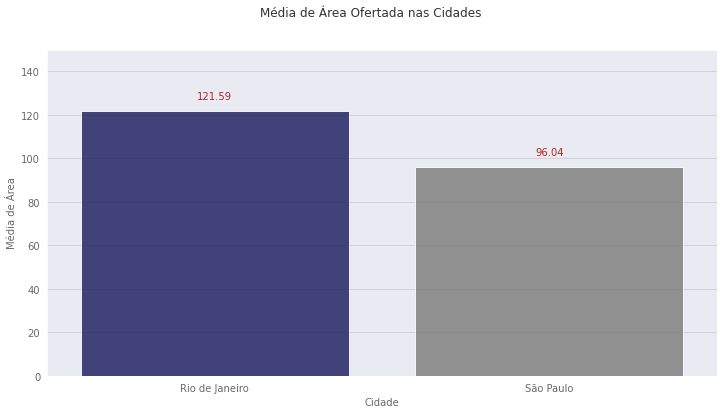

In [0]:
# Mean offered Area per city

media_rj = pd_rio['Area'].mean()
media_sp = pd_sp['Area'].mean()

df_means= pd.DataFrame({'Cidade': ['Rio de Janeiro', 'São Paulo'], 'Média de Área': [ media_rj, media_sp]})

# Plot a bar chart 
fig, axes = plt.subplots(figsize= (12,6))
fig.suptitle('Média de Área Ofertada nas Cidades')
ax1 = sns.barplot(x= 'Cidade', y= 'Média de Área', data = df_means, alpha= 0.85)
ax1.bar_label (ax1.containers[0], fontsize= 10, color='firebrick', padding= 10, fmt= "%.2f")
ax1.set_ylim(0, 150)

plt.show()

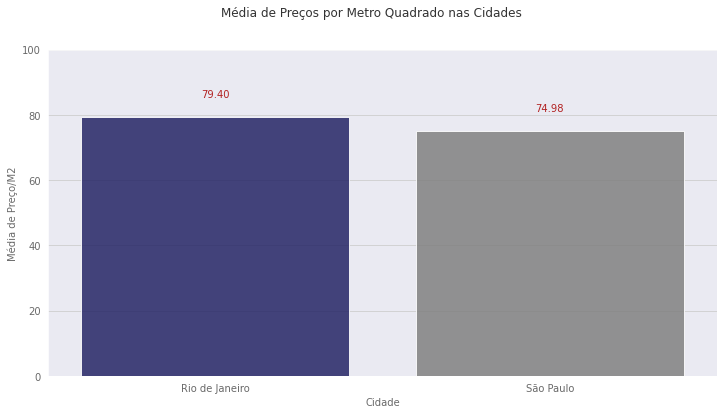

In [0]:
# Mean prices per square meter

m2_rio = (pd_rio['Preco'] / pd_rio['Area']).replace([np.inf, -np.inf], np.nan).dropna().mean()
m2_sp = (pd_sp['Preco'] / pd_sp['Area']).replace([np.inf, -np.inf], np.nan).dropna().mean()

df_means= pd.DataFrame({'Cidade': ['Rio de Janeiro', 'São Paulo'], 'Média de Preço/M2': [m2_rio, m2_sp]})

# Plot a bar chart 
fig, axes = plt.subplots(figsize= (12,6))
fig.suptitle('Média de Preços por Metro Quadrado nas Cidades')
ax1 = sns.barplot(x= 'Cidade', y= 'Média de Preço/M2', data = df_means, alpha= 0.85)
ax1.bar_label (ax1.containers[0], fontsize= 10, color='firebrick', padding= 18, fmt= "%.2f")
ax1.set_ylim(0, 100)

plt.show()

In [0]:
# Compute diferences in percentage between means

m_preco_rj = pd_rio['Preco'].mean()
m_preco_sp = pd_sp['Preco'].mean()
dif_preco = ((m_preco_rj - m_preco_sp)  / m_preco_rj) * 100
print(f'A diferença entre os Preços de Aluguel é de {dif_preco:.2f}%')

m_cond_rj = pd_rio['Condominio'].mean()
m_cond_sp = pd_sp['Condominio'].mean()
dif_cond = ((m_cond_rj - m_cond_sp)  / m_cond_rj) * 100
print(f'A diferença entre os preços de Condomínio é de {dif_cond:.2f}%')

m_iptu_rj = pd_rio['Iptu'].mean()
m_iptu_sp = pd_sp['Iptu'].mean()
dif_iptu = ((m_iptu_rj - m_iptu_sp)  / m_iptu_rj) * 100
print(f'A diferença entre os preços de Iptu é de {dif_iptu:.2f}%')

m_area_rj = pd_rio['Area'].mean()
m_area_sp = pd_sp['Area'].mean()
dif_area = ((m_area_rj - m_area_sp)  / m_area_rj) * 100
print(f'A diferença entre as Áreas das ofertas é de {dif_area:.2f}%')

dif_m2 = ((m2_rio - m2_sp) / m2_rio) * 100
print(f'A diferença entre os preços de aluguel por Metro Quadrado é de {dif_m2:.2f}%')


A diferença entre os Preços de Aluguel é de 30.93%
A diferença entre os preços de Condomínio é de 31.49%
A diferença entre os preços de Iptu é de 56.67%
A diferença entre as Áreas das ofertas é de 21.01%
A diferença entre os preços de aluguel por Metro Quadrado é de 5.58%


#####Comparação das médias de preços entre Rio e São Paulo

* Evidente e significativa diferença nas médias de todos os preços comparados. O que pode explicar estas diferenças? Apenas o fato de ser um mercado com menos ofertas e maior densidade populacional nos bairros da Zona Sul?

* No Rio de Janeiro, os aluguéis na Zona Sul são em média 30%  mais caros do que na Zona Oeste de São Paulo.

* Os preços de condomínio no Rio de Janeiro também são em média 31% mais caros do que em São Paulo.

* Já os preços de Iptu são ainda mais caros no Rio de Janeiro do que em São Paulo: 56% maiores.

* O tamanho médio em Área das ofertas 21% é maior no Rio de Janeiro do que em São Paulo, O que pode justificar a diferença nos preços.

* Em contrapartida, o preço médio do m2 é similar, com apenas 5% de diferença, provavelemte as ofertas disponíveis em São Paulo são de apartamentos menores do que os do Rio (conforme a média de áreas confirma), para fazer uma afirmação mais fundamentada, seria necessário investigar mais o tipo de ofertas.

###Estatísticas Multivariadas - Agrupamentos por Bairro

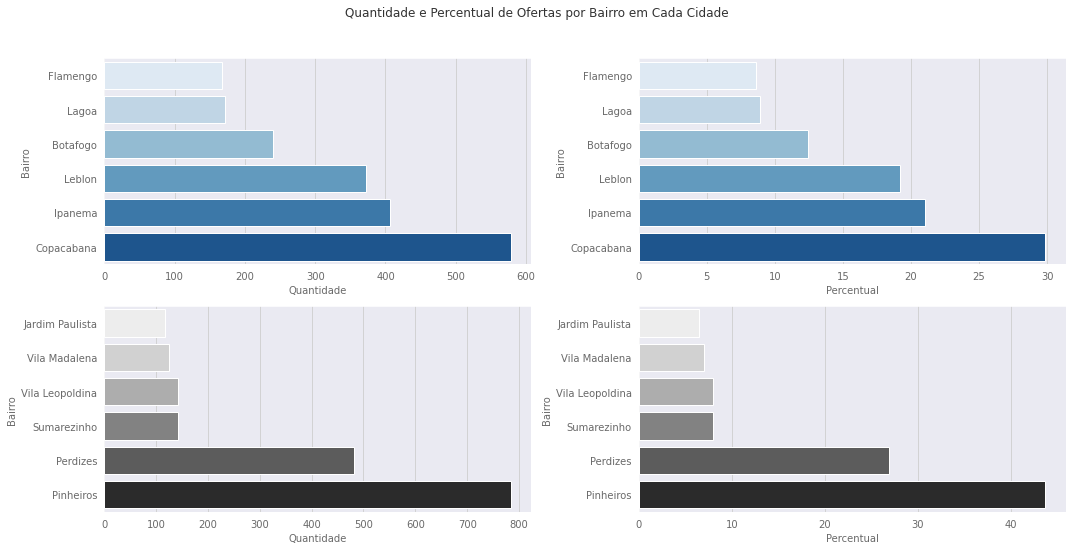

In [0]:
# Offers grouped by Bairro - Most frequent

group_rio = pd_rio.groupby(['Bairro']).size().reset_index(name='Quantidade')
group_rio_top6 = group_rio.sort_values(by='Quantidade', ascending=False).head(6)
group_rio_top6_sorted = group_rio_top6.sort_values(by='Quantidade', ascending=True)
group_rio_top6_sorted['Percentual'] = round(group_rio_top6_sorted['Quantidade'] / group_rio_top6_sorted['Quantidade'].sum() * 100,2)

group_sp = pd_sp.groupby(['Bairro']).size().reset_index(name='Quantidade')
group_sp_top6 = group_sp.sort_values(by='Quantidade', ascending=False).head(6)
group_sp_top6_sorted = group_sp_top6.sort_values(by='Quantidade', ascending=True)
group_sp_top6_sorted['Percentual'] = round(group_sp_top6_sorted['Quantidade'] / group_sp_top6_sorted['Quantidade'].sum() * 100,2)

# Plot a bar chart 
fig, axes = plt.subplots(2, 2, figsize=(15,8))
fig.suptitle('Quantidade e Percentual de Ofertas por Bairro em Cada Cidade')

sns.barplot(y= 'Bairro', x= 'Quantidade', data = group_rio_top6_sorted, ax= axes[0,0], palette='Blues')
sns.barplot(y= 'Bairro', x= 'Percentual', data = group_rio_top6_sorted, ax= axes[0,1], palette='Blues')
sns.barplot(y= 'Bairro', x= 'Quantidade', data = group_sp_top6_sorted, ax= axes[1,0], palette='Greys')
sns.barplot(y= 'Bairro', x= 'Percentual', data = group_sp_top6_sorted, ax= axes[1,1], palette='Greys')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

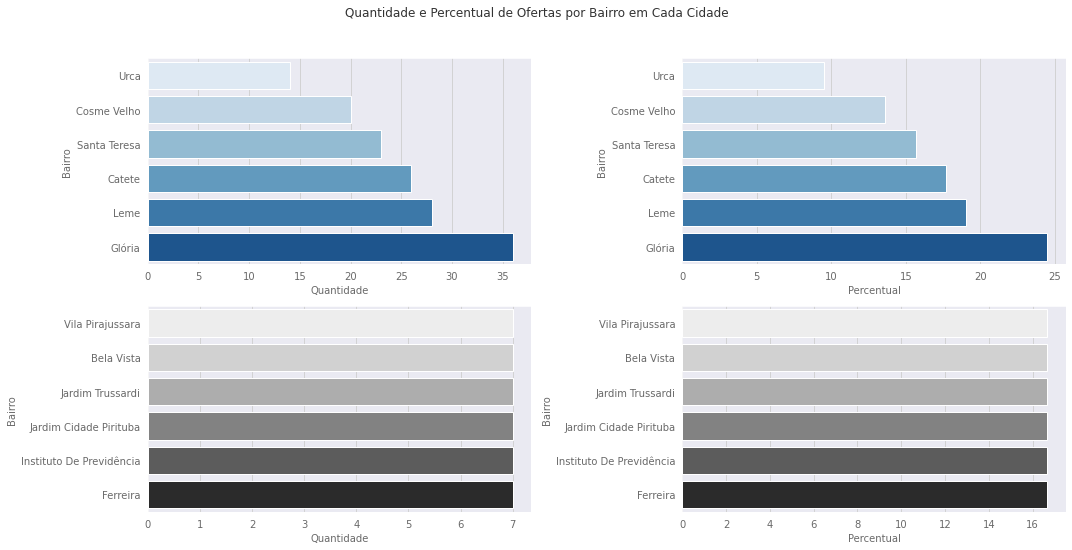

In [0]:
# Offers grouped by Bairro - Less frequent

group_rio = pd_rio.groupby(['Bairro']).size().reset_index(name='Quantidade')
group_rio = group_rio[group_rio['Quantidade'] > 6]
group_rio_bottom6 = group_rio.sort_values(by='Quantidade', ascending=True).head(6)
group_rio_bottom6['Percentual'] = round(group_rio_bottom6['Quantidade'] / group_rio_bottom6['Quantidade'].sum() * 100,2)

group_sp = pd_sp.groupby(['Bairro']).size().reset_index(name='Quantidade')
group_sp = group_sp[group_sp['Quantidade'] > 6]
group_sp_bottom6 = group_sp.sort_values(by='Quantidade', ascending=True).head(6)
group_sp_bottom6['Percentual'] = round(group_sp_bottom6['Quantidade'] / group_sp_bottom6['Quantidade'].sum() * 100,2)

# Plot a bar chart 
fig, axes = plt.subplots(2, 2, figsize=(15,8))
fig.suptitle('Quantidade e Percentual de Ofertas por Bairro em Cada Cidade')

sns.barplot(y= 'Bairro', x= 'Quantidade', data = group_rio_bottom6, ax= axes[0,0], palette='Blues')
sns.barplot(y= 'Bairro', x= 'Percentual', data = group_rio_bottom6, ax= axes[0,1], palette='Blues')
sns.barplot(y= 'Bairro', x= 'Quantidade', data = group_sp_bottom6, ax= axes[1,0], palette='Greys')
sns.barplot(y= 'Bairro', x= 'Percentual', data = group_sp_bottom6, ax= axes[1,1], palette='Greys')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

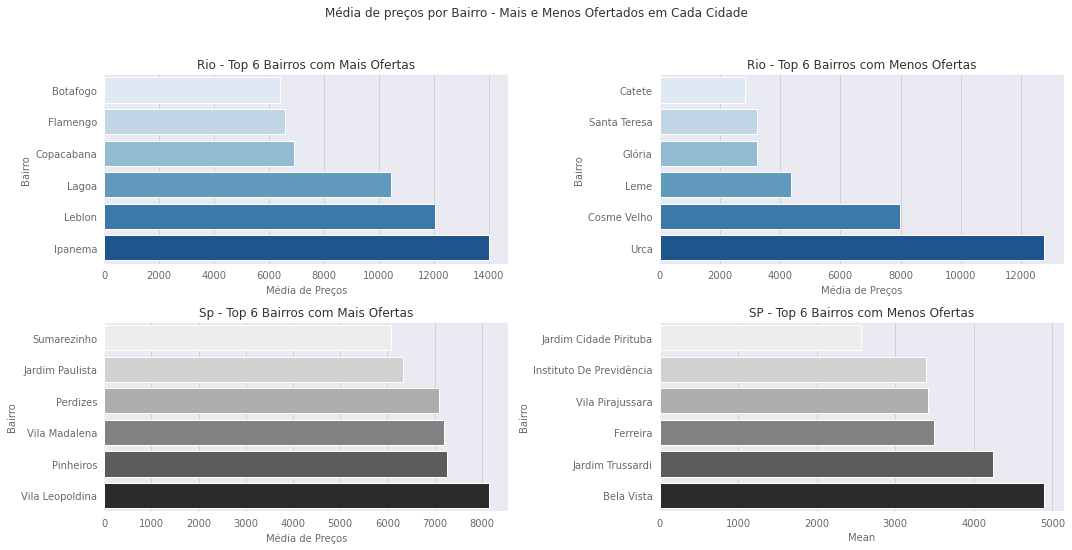

In [0]:
# Mean price by bairro 10 most expensive and 10 cheaper

group_rio = pd_rio.groupby(['Bairro']).agg(Mean= ('Preco', 'mean'), Quantidade= ('Preco', 'count')).reset_index()
group_rio_top6 = group_rio.sort_values(by='Quantidade', ascending=False).head(6)
group_rio_bottom6 = group_rio[group_rio['Quantidade'] > 6].sort_values(by='Quantidade', ascending=True).head(6)

group_sp = pd_sp.groupby(['Bairro']).agg(Mean= ('Preco', 'mean'), Quantidade= ('Preco', 'count')).reset_index()
group_sp_top6 = group_sp.sort_values(by='Quantidade', ascending=False).head(6)
group_sp_bottom6 = group_sp[group_sp['Quantidade'] > 6].sort_values(by='Quantidade', ascending=True).head(6)

# Plot a bar chart 
fig, axes = plt.subplots(2, 2, figsize=(15,8))
fig.suptitle('Média de preços por Bairro - Mais e Menos Ofertados em Cada Cidade')

sns.barplot(y= 'Bairro', x= 'Mean', data = group_rio_top6.sort_values(by='Mean'), ax= axes[0,0], palette='Blues')
axes[0,0].set_title('Rio - Top 6 Bairros com Mais Ofertas')
axes[0,0].set_xlabel('Média de Preços')

sns.barplot(y= 'Bairro', x= 'Mean', data = group_rio_bottom6.sort_values(by='Mean'), ax= axes[0,1], palette='Blues')
axes[0,1].set_title('Rio - Top 6 Bairros com Menos Ofertas')
axes[0,1].set_xlabel("Média de Preços")

sns.barplot(y= 'Bairro', x= 'Mean', data = group_sp_top6.sort_values(by='Mean'), ax= axes[1,0], palette='Greys')
axes[1,0].set_title('Sp - Top 6 Bairros com Mais Ofertas')
axes[1,0].set_xlabel('édia de Preços')

sns.barplot(y= 'Bairro', x= 'Mean', data = group_sp_bottom6.sort_values(by='Mean'), ax= axes[1,1], palette='Greys')
axes[1,1].set_title('SP - Top 6 Bairros com Menos Ofertas')
axes[1,0].set_xlabel('Média de Preços')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


* No Rio de Janeiro os bairros de Copacabana e Ipanema lideram a quantidade de  ofertas, concentrando a grande maioria das ofertas, mais de 50% dos anúncios presentes neste dataset. Em terceiro lugar o bairro do Leblon, com mais quase 20% das ofertas. Os bairros da Urca e do Cosme Velho são os que apresentam menor quantidade de anúncios.

* Ipanema é o bairro no Rio que apresenta maior quantidade de ofertas e também maior preço médio (R$ 14.000,00), seguido ,pelo Leblon com preço médio de R$ 12.000,00. Dentre os 6 bairros que aparecem mais neste dataset, Botafogo e Flamengo são os bairros om menor preço médio, em torno de R$ 6.000,00. Quando olhamos os bairros com menos ofertas preesentes neste conjunto de dados, Urca é o bairro com preço médio mais alto, em torno de R$ 13.000,00, e od bairros do Catete, Sta. Teresa e Glória são os bairros que possuem menor preço médio, mais ou menos empatados tanto em número de ofertas quanto de valor médio, em torno de R$ 3.500,00.

* Em São Paulo Os Bairros de Pinheiros e Perdizes lideram na quantidade de anúncios com em torno de 45% e 25% dos anúncios, respectivamente. Em seguida aparece o bairro do Sumarezinho, Vila Leopoldina, Vila Madalena e Jarim Paulista, odos mis ou menos empatados com aproximadamente 8% cada. Os bairros da Zona Oeste de São Paulo mais afastados do centro ficam na anterna em quantidade de anúncios, todos empatados com aproximadamente a mesma quantidade.

* Vila Leopoldina aparece entre os bairros com maior média de pre;o, em torno de R$ 8.000,00, depois figuram Pinheiros, Perdizes e Vila Madalena, mais ou menos empatados com preço médio de R$ 7.000,00. Em São Paulo, dentre os 6 bairros com mais anúncios, a diferença média de preços é pequena, sempre em torno de R$ 1.000,00 de diferença. Já entre os bairros que menos aparecem neste dataset, o bairro da Bela Vista é o mais caro, com preço médio de aproximadamente R$ 5.000,00. E os bairros mais baratos são Jardim Pirajussara e Instituto de Previdência, com preço médio de R$ 3.500,00 e Jardim Cidade Pirituba, com preço médio abaixo de R$ 3.000,00. 


#### Agregações por Tipologia - Dormitórios

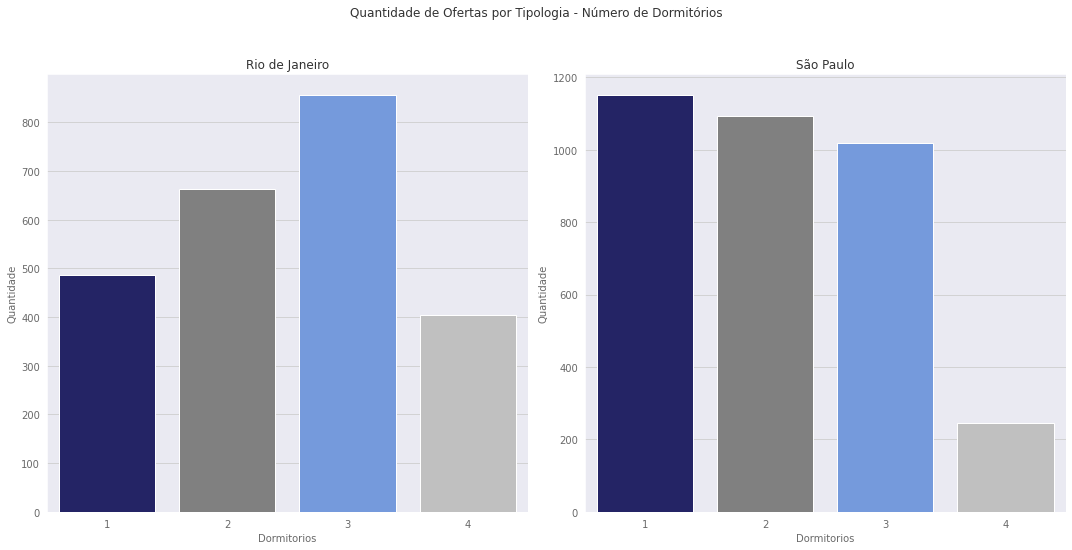

In [0]:
# How many properties there are in the dataset grouped by number of bedrooms

pd_rio_filter = pd_rio[pd_rio["Dormitorios"] != "4-5"].copy()
pd_rio_filter['Dormitorios'] = pd.to_numeric(pd_rio_filter['Dormitorios'], errors= 'coerce')
pd_rio_filter = pd_rio_filter[(pd_rio_filter["Dormitorios"] >= 1) & (pd_rio_filter["Dormitorios"] < 5)]
bedrooms_rio = pd_rio_filter.groupby(['Dormitorios']).agg(Mean= ('Preco', 'mean'), Quantidade= ('Dormitorios', 'count')).reset_index()

pd_sp_filter = pd_sp[pd_sp['Dormitorios'] != '4-5'].copy()
pd_sp_filter['Dormitorios'] = pd.to_numeric(pd_sp_filter['Dormitorios'], errors= 'coerce')
pd_sp_filter = pd_sp_filter[(pd_sp_filter["Dormitorios"] >= 1) & (pd_sp_filter["Dormitorios"] < 5)]
bedrooms_sp = pd_sp_filter.groupby(['Dormitorios']).agg(Mean= ('Preco', 'mean'), Quantidade= ('Dormitorios', 'count')).reset_index()

# Plot a bar chart 
fig, axes = plt.subplots(1,2, figsize=(15,8))
fig.suptitle('Quantidade de Ofertas por Tipologia - Número de Dormitórios')

sns.barplot(x= 'Dormitorios', y= 'Quantidade', data = bedrooms_rio, ax= axes[0], palette= colors)
axes[0].set_title('Rio de Janeiro')
sns.barplot(x= 'Dormitorios', y= 'Quantidade', data = bedrooms_sp, ax= axes[1], palette= colors)
axes[1].set_title('São Paulo')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


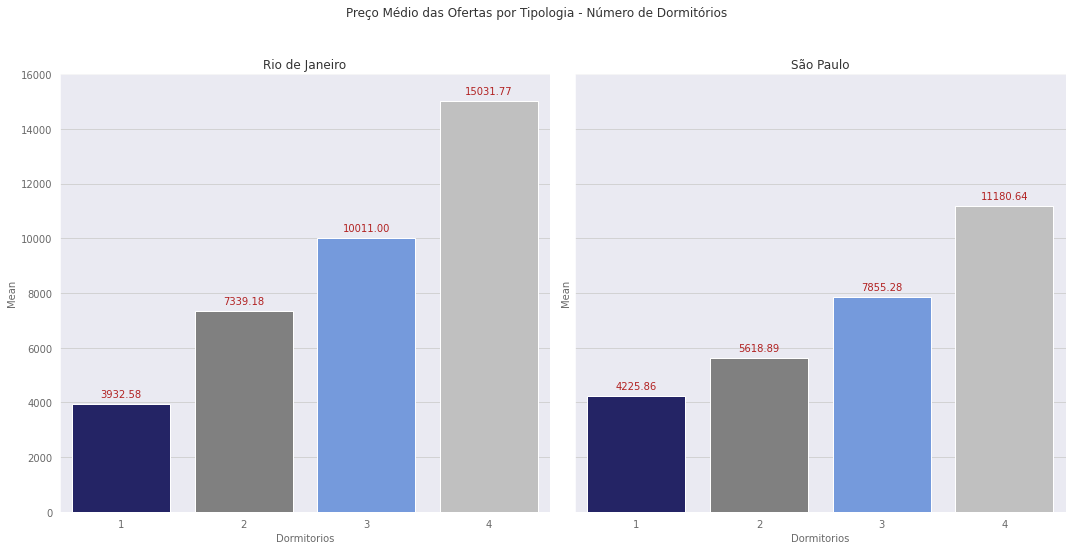

In [0]:
# Mean price grouped by number of bedrooms

pd_rio_filter = pd_rio[pd_rio["Dormitorios"] != "4-5"].copy()
pd_rio_filter['Dormitorios'] = pd.to_numeric(pd_rio_filter['Dormitorios'], errors= 'coerce')
pd_rio_filter = pd_rio_filter[(pd_rio_filter["Dormitorios"] >= 1) & (pd_rio_filter["Dormitorios"] < 5)]
bedrooms_rio = pd_rio_filter.groupby(['Dormitorios']).agg(Mean= ('Preco', 'mean'), Quantidade= ('Dormitorios', 'count')).reset_index()

pd_sp_filter = pd_sp[pd_sp['Dormitorios'] != '4-5'].copy()
pd_sp_filter['Dormitorios'] = pd.to_numeric(pd_sp_filter['Dormitorios'], errors= 'coerce')
pd_sp_filter = pd_sp_filter[(pd_sp_filter["Dormitorios"] >= 1) & (pd_sp_filter["Dormitorios"] < 5)]
bedrooms_sp = pd_sp_filter.groupby(['Dormitorios']).agg(Mean= ('Preco', 'mean'), Quantidade= ('Dormitorios', 'count')).reset_index()

# Plot a bar chart 
fig, axes = plt.subplots(1,2, figsize=(15,8), sharey= True)
fig.suptitle('Preço Médio das Ofertas por Tipologia - Número de Dormitórios')

sns.barplot(x= 'Dormitorios', y= "Mean", data = bedrooms_rio, ax= axes[0], palette= colors)
axes[0].set_title('Rio de Janeiro')
sns.barplot(x= 'Dormitorios', y= "Mean", data = bedrooms_sp, ax= axes[1], palette= colors)
axes[1].set_title('São Paulo')

axes[0].bar_label(axes[0].containers[0], fontsize= 10, color='firebrick', padding= 5, fmt= "%.2f")
axes[1].bar_label(axes[1].containers[0], fontsize= 10, color='firebrick', padding= 5, fmt= "%.2f")

for ax in axes:
    ax.set_ylim(0, 16000)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


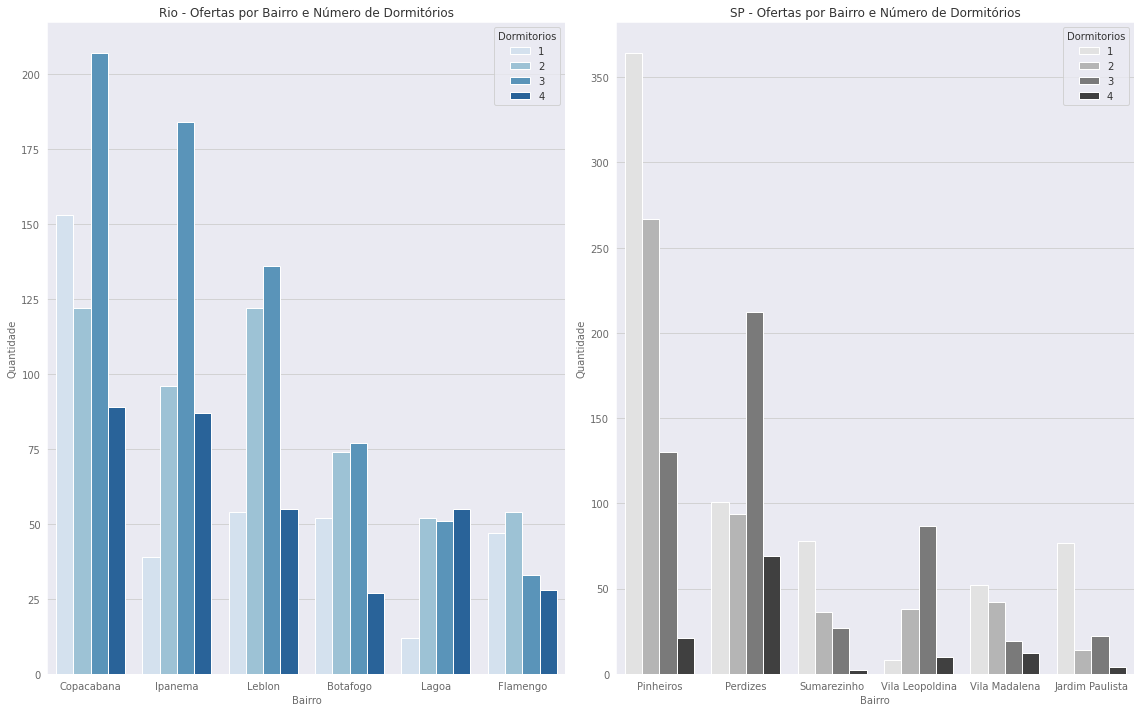

In [0]:
# Group by bairro and dormitorios

top_bairros_rio = (pd_rio_filter['Bairro'].value_counts().head(6).index)
rio_group = (pd_rio_filter[pd_rio_filter['Bairro'].isin(top_bairros_rio)].groupby(['Bairro', 'Dormitorios']).size().reset_index(name='Quantidade'))
rio_order = (rio_group.groupby('Bairro')['Quantidade'].sum().sort_values(ascending=False).index)
rio_group['Bairro'] = pd.Categorical(rio_group['Bairro'], categories=rio_order, ordered=True)

top_bairros_sp = pd_sp_filter['Bairro'].value_counts().head(6).index
sp_group = (pd_sp_filter[pd_sp_filter['Bairro'].isin(top_bairros_sp)].groupby(['Bairro', 'Dormitorios']).size().reset_index(name='Quantidade'))
sp_order = (sp_group.groupby('Bairro')['Quantidade'].sum().sort_values(ascending=False).index)
sp_group['Bairro'] = pd.Categorical(sp_group['Bairro'], categories=sp_order, ordered=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

sns.barplot(data=rio_group, y='Quantidade', x='Bairro', hue='Dormitorios', ax=axes[0], palette='Blues')
axes[0].set_title('Rio - Ofertas por Bairro e Número de Dormitórios')

sns.barplot(data=sp_group, y='Quantidade', x='Bairro', hue='Dormitorios', ax=axes[1], palette='Greys')
axes[1].set_title('SP - Ofertas por Bairro e Número de Dormitórios')

plt.tight_layout()
plt.show()


* Os imóveis com 3 quartos constituem a maioria das ofertas para aluguel no Rio de Janeiro, seguido pelos imóveis de 2 quartos e depois os de 1 quarto. Já em São Paulo, as ofertas de 1 dormitório predominam neste dataset, seguidas pelas ofertas de imóveis com 2 dormitórios e depois 3 dormitórios.

* Os imóveis no Rio de Janeiro com 4 quartos estão custando em média R$ 15.000,00, enquanto em São Paulo esta tipologia custa em média R$ 11.000,00. Os imóveis com 3 quartos custam, respectivamente R$ 11.000,00 e R$ 7.800,00. Os apartamentos com dois quartos custam no Rio em torno de R$ 7.300,00 enquanto em São Paulo o valor médio é de R$ 5.600,00. A virada aparece nos imóveis de um dormitório, que são a grande estrela do mercado imobiliário paulista atualmente (tipologia com mais lançamentos, apartamentos tipo studio) e o valor médio em São Paulo está em torno de R$ 4.200,00, enquanto apartamentos de 1 dormitório no Rio estão custando um pouco menos, em torno de R$ 3.900,00. Os apartamentos de um dormitório são os únicos que em São Paulo custam mais caro do que no Rio.

* Quando olhamos para o agrupamento de apartamentos por tipologia e bairro, percebemos que no Rio de Janeiro a maioria dos anúncios são de imóveis com 3 dormitórios e estão localizados em bairros mais tradicionais como Copacabana, Ipanema e Leblon. Já em São Paulo, os apartamentos de 3 dormitórios são maioria no Bairro de Perdizes, que é um bairro mais tradicional e consolidado, e na Vila Leopoldina, que apresenta maior quantidade de lançamentos com apartamentos de 3 dormitórios. Por outro lado, no Rio os apartamentos com um quarto aparecem com mais destaque no bairro de Copacabana, Leblon e Flamengo. Em São Paulo o bairro de Pinheiros lidera disparado na oferta de apartamentos de 1 quarto seguido pela oferta de apartamentos de 2 quartos.